In [67]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from torchsummary import  summary

import matplotlib.pyplot as plt

# Create gaussian blurs with different widths

In [68]:
nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# initialize tensors containing images and labels
images = torch.zeros(nGauss,1,imgSize,imgSize)
labels = torch.zeros(nGauss,3)

for i in range(nGauss):

  # location and width parameters
  loc = 2*np.random.randn(2)
  wid = np.random.rand()*10 + 5

  # create the gaussian with random centers
  G  = np.exp( -( (X-loc[0])**2 + (Y-loc[1])**2) / wid )
  G  = G + np.random.randn(imgSize,imgSize)/10

  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i,:] = torch.Tensor( [loc[0],loc[1],wid] )

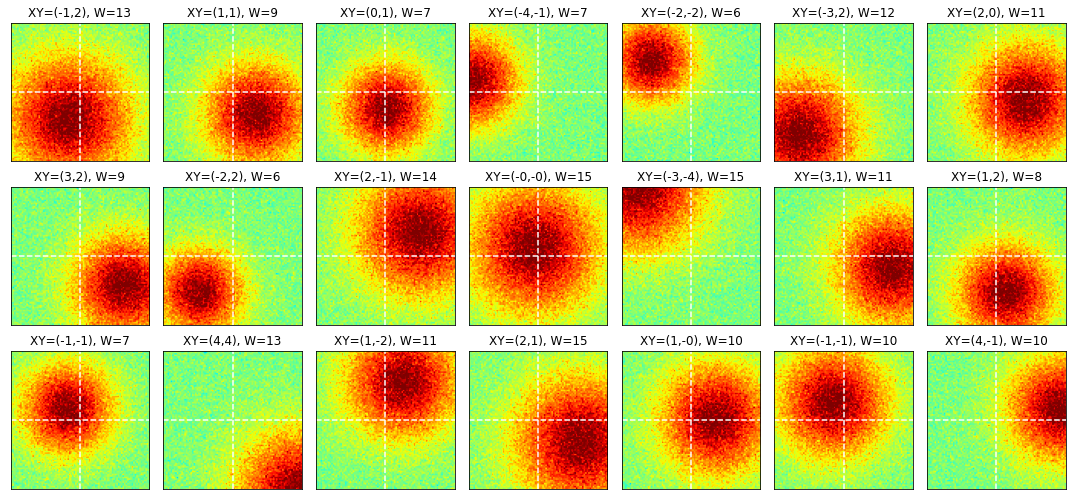

In [69]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,7))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nGauss)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='upper')
  ax.set_title(f'XY=({labels[whichpic,0]:.0f},{labels[whichpic,1]:.0f}), W={labels[whichpic,2]:.0f}')
  ax.plot([-4,4],[0,0],'w--')
  ax.plot([0,0],[-4,4],'w--')
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

# Create train/test groups using Dataloader

In [84]:
#step 2: use scikit learn to split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# step 3: convert into pytorch dataset
train_data = torch.utils.data.TensorDataset(X_train,y_train)
test_data = torch.utils.data.TensorDataset(X_test,y_test)

#step4: translate into dataloader object
train_loader = DataLoader(train_data,batch_size=16,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [85]:
# check size( should be images X channel X width X height)
print(test_loader.dataset.tensors[0].shape)

torch.Size([300, 1, 91, 91])


In [86]:
for i in train_loader:
  print(i[0].shape)

torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 91, 91])
torch.Size([16, 1, 9

# Create a Dl model

In [96]:
# create a class for the model
def make_net():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      # all layers in one go using nn.Sequential
      self.enc = nn.Sequential(

          # conv/pool block 1
          nn.Conv2d(1,6,3,padding=1),  # output size: (91+2*1-3)/1 + 1 = 91
          nn.ReLU(),                   #
          nn.AvgPool2d(2,2),           # output size: 91/2 = 45

          # conv/pool block 2
          nn.Conv2d(6,4,3,padding=1),  # output size: (45+2*1-3)/1 + 1 = 45
          nn.ReLU(),                   #
          nn.AvgPool2d(2,2),           # output size: 45/2 = 22

          # linear decision layer
          nn.Flatten(),                # vectorize conv2 block output
          nn.Linear(22*22*4,50),       # output size: 50
          nn.Linear(50,3),             # output size: 3
      )

    def forward(self,x):
      return self.enc(x)

  # create the model instance
  net = gausnet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [97]:
#Sanity test
net,lossfun,optimizer = make_net()
X,y = next(iter(train_loader))
y_hat = net(X)
print('yhat',y_hat.shape)
loss = lossfun(y_hat,y)
print(loss.detach())

yhat torch.Size([16, 3])
tensor(45.3555)


In [89]:
#count the total number of parameters in the model
summary(net,(1,imgSize,imgSize),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 50]          96,850
            Linear-9                    [-1, 3]             153
Total params: 97,283
Trainable params: 97,283
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.00
Params size (MB): 0.37
Estimated Total Size (MB): 1.41
---------------------------------------------

# Train model

In [98]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 30

  # create a new model
  net,lossfun,optimizer = make_net()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # compare the following really long line of code to the training accuracy lines
    testLoss[epochi] = loss.item()

  # end epochs

  # function output
  return trainLoss,testLoss,net

In [99]:
train_loss,test_loss,net = function2trainTheModel()

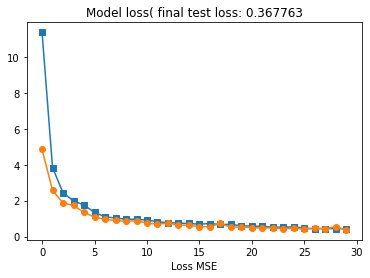

In [100]:
plt.plot(train_loss,'s-',label='Train')
plt.plot(test_loss,'o-',label='Test')
plt.xlabel('Loss MSE')
plt.title('Model loss( final test loss: %2f'%test_loss[-1])

plt.show()

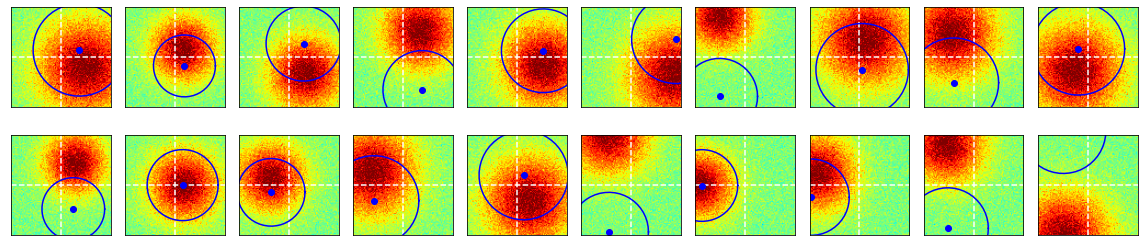

In [101]:
# visualize some images

X,Y = next(iter(test_loader)) # extract X,y from test dataloader
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(16,4))

th = np.linspace(0,2*np.pi)

for i,ax in enumerate(axs.flatten()):

  # get the Gaussian and draw it, and draw the white guide-lines
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='upper')
  ax.plot([-4,4],[0,0],'w--')
  ax.plot([0,0],[-4,4],'w--')

  # compute the model's prediction
  cx = yHat[i][0].item() # center X
  cy = yHat[i][1].item() # center Y
  rd = yHat[i][2].item() # radius

  # and draw it
  x = cx + np.cos(th)*np.sqrt(rd)
  y = cy + np.sin(th)*np.sqrt(rd)
  ax.plot(x,y,'b')
  ax.plot(cx,cy,'bo')

  # some final plotting niceties
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlim([-4,4])
  ax.set_ylim([-4,4])

plt.tight_layout()
plt.show()

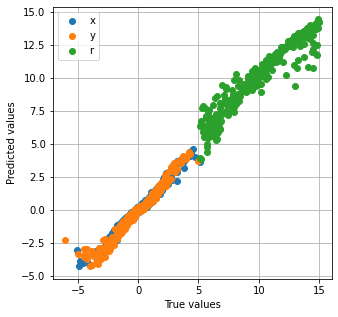

In [102]:
fig = plt.figure(figsize=(5,5))

for i in range(3):
  plt.plot(Y[:,i].detach(),yHat[:,i].detach(),'o')

plt.legend(['x','y','r'])
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.grid()
plt.show()